# <u> DSCI 100 Group 16 Project<u>

### Predicting Response for a Superstore Marketing Campaign

## <u> Introduction<u>

The marketing budgets for companies are skyrocketing these days, but looking at the depression coming in companies are cutting down on the marketing budgets and are finding much more better and economical ways to market their product. In today's competitive market, businesses often offer various discounts and benefits to their customers to retain them and encourage future purchases. One such strategy is the introduction of membership programs, which offer exclusive deals and discounts to customers who subscribe to them. (https://www.cnbc.com/2019/05/22/hooked-how-costco-turns-customers-into-fanatics.html)

In this project, we will utilize a dataset(https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset). This data set has over 2200 observations. Each observation has 14 variables which are Income, Recency, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, Response, Childhome, Age, Total_Spent, Weeks_Customer, Relationship. However for this project the main focus will be on the columns marital status, income, number of children, age, total spent, and time as customer.
    
Through this project we aim to predict “will an existing customer at the Superstore will be giving a positive response to their new gold membership offer which gives them 20% off for \\$499 which is \\$999 on regular days?”

### Modifying the data set

The dataset we are going to use comes from Kaggle: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset.

The data set is already tidy, but we made the data set a bit more usable by:
- removing rows with 'NA'
- removing discrete variables
- creating a column for total children
- creating a column for total grocery spending
- converting the birthday column to age
- creating a column for time as customer
- changing the marital status to Yes/No factor
- changing the response variable to a factor

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:
set.seed(16)
url <- "https://raw.githubusercontent.com/nchan315/DSCI_100_007_16_Project/main/superstore_data.csv"
data <- read_csv(url)

store_data <- data |>
    # removing rows with NA
    na.omit() |>

    # removing discrete variables
    select(-Id, -Education, -Complain) |>

    # summing the number of children
    mutate(Childhome = Kidhome + Teenhome) |>
    select(-Kidhome, -Teenhome) |>

    # creating an age column
    mutate(Age = 2022 - Year_Birth) |>
    select(-Year_Birth) |>

    # combining the amount spent on food
    mutate(Total_Spent = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts) |>
    select(-MntWines, -MntFruits, -MntMeatProducts, -MntFishProducts, -MntSweetProducts) |>

    # calculating weeks that the customer has been a customer
    mutate(Dt_Customer = as.Date(Dt_Customer, "%m/%d/%Y")) |>
    mutate(Weeks_Customer = difftime("2022-12-31", Dt_Customer, units = "weeks")) |>
    mutate(Weeks_Customer = as.numeric(Weeks_Customer)) |>
    select(-Dt_Customer) |>

    # changing martial status into 2 distinctions
    mutate(Relationship = case_when(Marital_Status == 'Married' | Marital_Status == 'Together' ~ 'Yes',
                                    Marital_Status !=  'Married' & Marital_Status != 'Together' ~ 'No')) |>
    select(-Marital_Status) |>
    mutate(Relationship = as.factor(Relationship)) |>

    # changing response to a factor
    mutate(Response = as.factor(Response))

glimpse(store_data)

Rows: 2240 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Education, Marital_Status, Dt_Customer
dbl (19): Id, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 2,216
Columns: 14
$ Income              <dbl> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 4…
$ Recency             <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MntGoldProds        <dbl> 218, 37, 30, 0, 34, 43, 65, 7, 5, 5, 26, 4, 102, 3…
$ NumDealsPurchases   <dbl> 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 2, 1, 1, 0, 4, 4,…
$ NumWebPurchases     <dbl> 4, 7, 3, 1, 3, 4, 10, 2, 6, 6, 5, 3, 3, 1, 25, 2, …
$ NumCatalogPurchases <dbl> 4, 3, 2, 0, 1, 7, 10, 1, 2, 2, 6, 1, 6, 1, 0, 1, 1…
$ NumStorePurchases   <dbl> 6, 7, 5, 2, 2, 5, 7, 3, 9, 9, 10, 6, 6, 2, 0, 5, 5…
$ NumWebVisitsMonth   <dbl> 1, 5, 2, 7, 7, 2, 6, 5, 4, 4, 1, 4, 1, 6, 1, 4, 4,…
$ Response            <fct> 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,…
$ Childhome           <dbl> 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 2,…
$ Age                 <dbl> 52, 61, 64, 55, 33, 64, 68, 55, 68, 68, 75, 43, 63…
$ Total_Spent         <dbl> 972, 540, 221, 11, 57, 1149, 1150, 89, 539, 539, 1…
$ Weeks_Customer

Our dataset has 14 variables, but we decided to focus on the variables: Relationship, Income, Age, Childhome, Total_Spent, and Weeks_Customer because they seemed like possible factors that would influence a positive or negative response.

In [5]:
store_data_reduced <- store_data |>
    select(Relationship, Income, Age, Childhome, Total_Spent, Weeks_Customer, Response)
glimpse(store_data_reduced)

Rows: 2,216
Columns: 7
$ Relationship   <fct> No, No, Yes, Yes, No, No, Yes, Yes, Yes, Yes, Yes, Yes,…
$ Income         <dbl> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 44931,…
$ Age            <dbl> 52, 61, 64, 55, 33, 64, 68, 55, 68, 68, 75, 43, 63, 41,…
$ Childhome      <dbl> 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 2, 1, 1…
$ Total_Spent    <dbl> 972, 540, 221, 11, 57, 1149, 1150, 89, 539, 539, 1182, …
$ Weeks_Customer <dbl> 445.7143, 445.8571, 450.5714, 425.4286, 438.7143, 458.7…
$ Response       <fct> 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0…


### Creating the Testing/Training Split
We split the data set by martial status (Relationship column) and split the data into 75% training and 25% testing sets.

In [6]:
# creating the 75% training 25% testing split
store_data_yes_split <- store_data_reduced |>
    filter(Relationship == "Yes") |>
    initial_split(prop = 0.75, strata = Response)
store_data_yes_train <- training(store_data_yes_split)
store_data_yes_test <- testing(store_data_yes_split)

store_data_no_split <- store_data_reduced |>
    filter(Relationship == "No") |>
    initial_split(prop = 0.75, strata = Response)
store_data_no_train <- training(store_data_no_split)
store_data_no_test <- testing(store_data_no_split)

glimpse(store_data_yes_train)
glimpse(store_data_yes_test)
glimpse(store_data_no_train)
glimpse(store_data_no_test)

Rows: 1,072
Columns: 7
$ Relationship   <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, …
$ Income         <dbl> 32474, 44931, 65324, 81044, 62499, 26872, 54809, 36634,…
$ Age            <dbl> 55, 55, 68, 75, 43, 41, 45, 68, 43, 46, 66, 66, 36, 32,…
$ Childhome      <dbl> 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 1, 1…
$ Total_Spent    <dbl> 11, 89, 539, 1182, 218, 40, 152, 305, 69, 381, 652, 652…
$ Weeks_Customer <dbl> 425.4286, 467.0000, 426.0000, 470.1429, 485.2857, 480.4…
$ Response       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
Rows: 358
Columns: 7
$ Relationship   <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, …
$ Income         <dbl> 67267, 65324, 4428, 34578, 66991, 76445, 75276, 77037, …
$ Age            <dbl> 64, 68, 53, 50, 68, 51, 57, 62, 53, 43, 60, 57, 69, 40,…
$ Childhome      <dbl> 1, 1, 1, 3, 0, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1…
$ Total_Spent    <dbl> 221, 539, 38, 8, 1241, 1375, 1019, 1113, 977, 668, 11

### Forward Selection

We used forward selection to determine the most relevant predictors for the different martial statuses.

This code was taken from 6.8 in online DSCI 100 textbook.

In [7]:
# getting column names
names <- colnames(store_data_yes_train |> select(-Response, -Relationship))
names

[1] "Income"         "Age"            "Childhome"      "Total_Spent"   
[5] "Weeks_Customer"

In [8]:
# Beginning of forward selection for Yes Relationship:
# (may take a while to run)

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
store_vfold <- vfold_cv(store_data_yes_train, v = 5, strata = Response)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Response", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        store_recipe <- recipe(as.formula(model_string), 
                                data = store_data_yes_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(store_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = store_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

In [ ]:
yes_plot <- accuracies |>
    ggplot(aes(size, accuracy)) +
        geom_line()
yes_plot

In [9]:
# Beginning of forward selection for No Relationship:
# (may take a while to run)

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
store_vfold <- vfold_cv(store_data_no_train, v = 5, strata = Response)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Response", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        store_recipe <- recipe(as.formula(model_string), 
                                data = store_data_no_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(store_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = store_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

accuracy_versus_k <- ggplot(acc, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

ERROR: Error in names[[j]]: subscript out of bounds


In [ ]:
no_plot <- accuracies |>
    ggplot(aes(size, accuracy)) +
        geom_line()
no_plot

FOR YES RELATIONSHIP: use Age+Total_Spent+Income+Childhome

FOR  NO RELATIONSHIP: use Age+Total_Spent+Income+Childhome

Now that we know the best combination of predictors to use to obtain the highest accuracy, we'll test for how many neighbors we should use to obtain the highest accuracy.

In [38]:
store_yes_recipe <- recipe(Response ~ Age+Total_Spent+Income+Childhome, 
                                data = store_data_yes_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

knn_results <- workflow() |>
          add_recipe(store_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = store_vfold, grid = 10) |>
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8889927,5,0.0009056986,Preprocessor1_Model1
2,roc_auc,binary,0.5010225,5,0.0017560152,Preprocessor1_Model1
3,accuracy,binary,0.8899317,5,0.0009583775,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.5052376,5,0.0186931996,Preprocessor1_Model7
15,accuracy,binary,0.8899317,5,0.0009583775,Preprocessor1_Model8
15,roc_auc,binary,0.4944047,5,0.0180985761,Preprocessor1_Model8


In [39]:
accuracies <- knn_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.8899317,5,0.0009583775,Preprocessor1_Model2
4,accuracy,binary,0.8899317,5,0.0009583775,Preprocessor1_Model3
6,accuracy,binary,0.8899317,5,0.0009583775,Preprocessor1_Model4
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,binary,0.8899317,5,0.0009583775,Preprocessor1_Model7
15,accuracy,binary,0.8899317,5,0.0009583775,Preprocessor1_Model8
2,accuracy,binary,0.8889927,5,0.0009056986,Preprocessor1_Model1


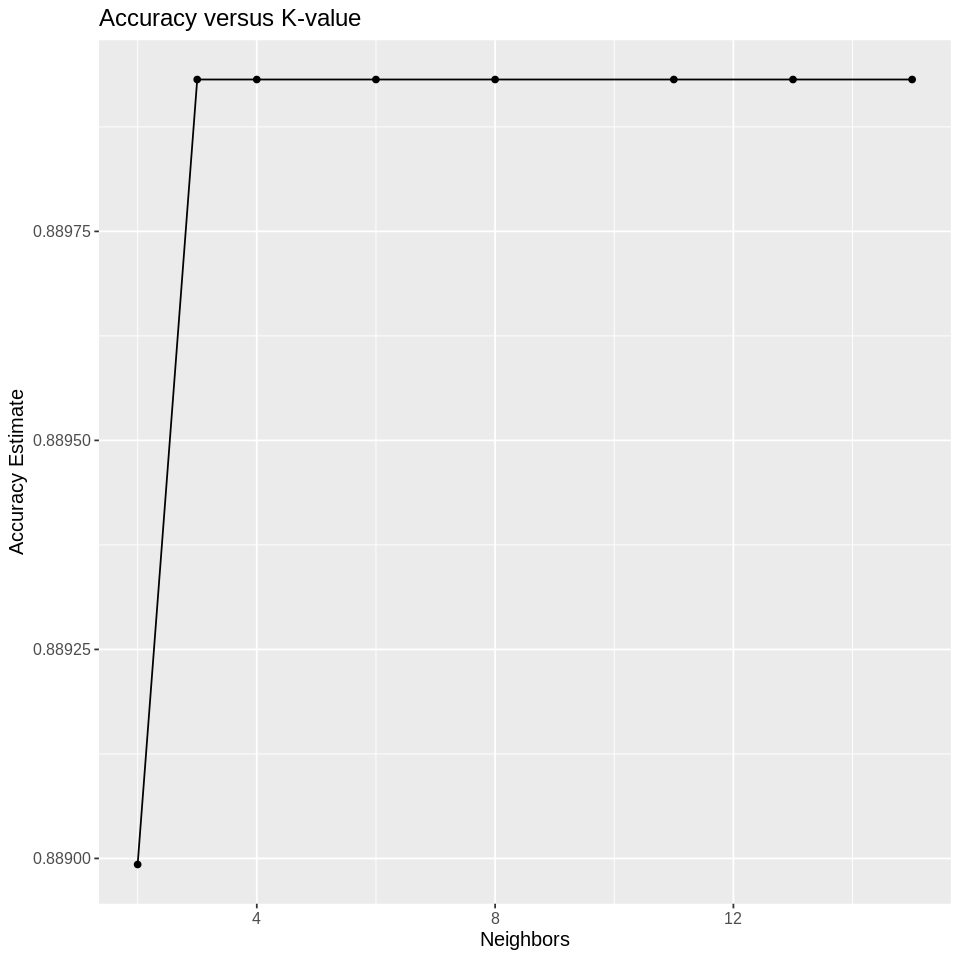

In [40]:
options(repr.plot.width = 8, repr.plot.height = 8)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    ggtitle("Accuracy versus K-value") +
    theme(text = element_text(size = 12))

accuracy_vs_k

In [57]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("classification")

store_yes_fit <- workflow() |>
    add_recipe(store_yes_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = store_data_yes_train)

In [58]:
store_yes_predictions <- predict(store_yes_fit, store_data_yes_test) |>
    bind_cols(store_data_yes_test)

store_yes_predictions

.pred_class,Relationship,Income,Age,Childhome,Total_Spent,Weeks_Customer,Response
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,Yes,67267,64,1,221,450.5714,0
0,Yes,65324,68,1,539,426.0000,0
0,Yes,4428,53,1,38,503.1429,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,Yes,42557,48,1,255,539.4286,0
0,Yes,20130,48,0,22,458.7143,0
0,Yes,65819,44,0,1320,526.2857,0


In [59]:
store_yes_accuracy <- store_yes_predictions |>
    metrics(truth = Response, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1) |>
    pull()

store_yes_accuracy

[1] 0.8938547

## Discussion:
summarize what you found

-discuss whether this is what you expected to find?

-discuss what impact could such findings have?

-discuss what future questions could this lead to?

## References